In [1]:
!pip install "ray[tune]" torch torchvision

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


# CIFAR10

El conjunto de datos CIFAR-10 es un conjunto de datos ampliamente utilizado en el campo de la visión por computadora y el aprendizaje automático. Aquí tienes una breve explicación:

`Nombre completo`: CIFAR-10 (Canadian Institute for Advanced Research - 10)

`Descripción`: CIFAR-10 es un conjunto de datos que consta de 60,000 imágenes de 32x32 píxeles en color (3 canales: rojo, verde y azul). Estas imágenes se dividen en 10 clases diferentes, con 6,000 imágenes por clase. Cada imagen pertenece a una de las siguientes categorías:  
        Avión  
        Automóvil  
        Pájaro  
        Gato  
        Ciervo  
        Perro  
        Rana  
        Caballo  
        Barco  
        Camión  

`Uso`: CIFAR-10 se utiliza principalmente para la evaluación y desarrollo de algoritmos de clasificación de imágenes. Es un conjunto de datos desafiante debido a su baja resolución y a la variabilidad en las condiciones de iluminación, orientación y posición de los objetos en las imágenes. Los investigadores y los practicantes de aprendizaje automático utilizan CIFAR-10 para entrenar y probar modelos de clasificación de imágenes, y se utiliza como un punto de referencia común para comparar el rendimiento de diferentes algoritmos.

`División de datos`: El conjunto de datos se divide en dos conjuntos: un conjunto de entrenamiento con 50,000 imágenes y un conjunto de prueba con 10,000 imágenes. Esto permite a los desarrolladores entrenar modelos en un conjunto de datos grande y luego evaluar su rendimiento en un conjunto de datos independiente para medir la generalización del modelo.

`Dificultades`: A pesar de su tamaño relativamente pequeño, CIFAR-10 presenta desafíos significativos debido a la diversidad de clases y la baja resolución de las imágenes. Los objetos en las imágenes son pequeños y a menudo están en contextos complejos, lo que hace que la clasificación sea una tarea desafiante.

En resumen, CIFAR-10 es un conjunto de datos ampliamente utilizado en la comunidad de aprendizaje automático y visión por computadora para tareas de clasificación de imágenes. Ayuda a los investigadores y desarrolladores a probar y mejorar sus algoritmos y modelos en un conjunto de datos estándar y desafiante.

# EDA

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

## Descargar los Datos

In [4]:
# Define the transformation
transform = transforms.Compose(
    [transforms.ToTensor()])

# Load the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


## Visualizaciones

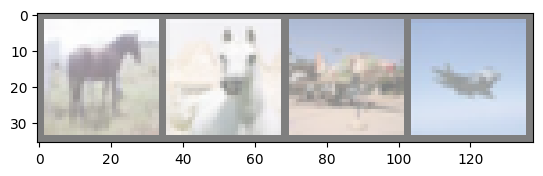

horse horse plane plane


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Distribucion de Clases

In [6]:
# import collections

# # Calculate class distribution
# class_counts = collections.Counter()
# for _, labels in trainloader:
#     class_counts.update(labels.numpy())

# # Plot class distribution
# labels, values = zip(*class_counts.items())
# indexes = np.arange(len(labels))
# width = 1

# plt.bar(indexes, values, width)
# plt.xticks(indexes + width * 0.5, labels)
# plt.show()


Podemos ver que en general las clases estan balanceadas.

# Entrenamiento

In [7]:
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

from torch.utils.data import DataLoader, random_split

Cuando uses arquitecturas o codigo generado por modelos preentrenados, asegurate de revisar que las `funciones de perdida` y el `output` de las redes sean correctos.

## Red Convolucional

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(128 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
class BatchNNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization for 64 feature maps

        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, 5)
        self.bn2 = nn.BatchNorm2d(128)  # Batch normalization for 128 feature maps

        self.fc1 = nn.Linear(128 * 5 * 5, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)  # Batch normalization for 256 features

        self.fc2 = nn.Linear(256, 84)
        self.bn_fc2 = nn.BatchNorm1d(84)   # Batch normalization for 84 features

        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))  # Added batch normalization
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))  # Added batch normalization
        x = x.view(-1, 128 * 5 * 5)
        x = nn.functional.relu(self.bn_fc1(self.fc1(x)))  # Added batch normalization
        x = nn.functional.relu(self.bn_fc2(self.fc2(x)))  # Added batch normalization
        x = self.fc3(x)
        return x


## Trial simple de Ray-Tune

### Definir funciones de train, val y test

In [10]:
import torch.nn.functional as F

EPOCH_SIZE = 512
TEST_SIZE = 256

def train_func(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    correct_train = 0
    total_train = 0
    total_loss = 0.0
    total_batches = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # Entrenemos con algunas observaciones para debuggear
        # if batch_idx * len(data) > EPOCH_SIZE:
        #     break
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        total_batches += 1

    average_loss = total_loss / total_batches
    accuracy_train = correct_train / total_train
    return average_loss, accuracy_train

def validate_func(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    total_batches = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss =  F.cross_entropy(outputs, target)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            total_batches += 1

    average_loss = total_loss / total_batches
    accuracy = correct / total
    return average_loss, accuracy

def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    total_batches = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # Evaluemos con algunas observaciones para debuggear
            # if batch_idx * len(data) > TEST_SIZE:
                # break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = F.cross_entropy(outputs, target)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            total_batches += 1

    average_loss = total_loss / total_batches
    accuracy = correct / total
    return average_loss, accuracy


### Loop de entrenamiento con Ray-Tune

In [11]:
import os
from ray import tune

class CIFAR10Trainable(tune.Trainable):
    def setup(self, config):
        # Data Setup
        cifar10_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])

        full_train_dataset = torchvision.datasets.CIFAR10(root="~/data",
                                                          train=True, download=True, transform=cifar10_transforms)
        test_dataset = torchvision.datasets.CIFAR10(root="~/data",
                                                    train=False, download=True, transform=cifar10_transforms)

        num_train = len(full_train_dataset)
        split_ratio = 0.8
        train_count = int(split_ratio * num_train)
        val_count = num_train - train_count

        train_dataset, val_dataset = random_split(full_train_dataset, [train_count, val_count])

        self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        batch_norm = config.get('batch_norm',False)
        if batch_norm:
            self.model = BatchNNet()
        else:
            self.model = Net()
        self.batch_norm = batch_norm
        self.model.to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=config["lr"])
        self.epochs = config["epochs"]
        self.config = config

    def step(self): # Esto define una epoca
        train_loss, train_acc = train_func(self.model, self.optimizer, self.train_loader)
        val_loss, val_acc = validate_func(self.model, self.val_loader)
        test_loss, test_acc = test_func(self.model, self.test_loader)

        # Esto es reportado a Ray Tune
        return {
            "batch_norm" : self.batch_norm,
            "lr":self.config["lr"],
            "train_loss": train_loss, "train_accuracy": train_acc,
            "val_loss": val_loss, "val_accuracy": val_acc,
            "test_loss": test_loss, "test_accuracy": test_acc
        }


    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
        torch.save({
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict()
        }, checkpoint_path)
        return checkpoint_dir  # Return only the directory

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])


### Ejecucion y Visualizacion

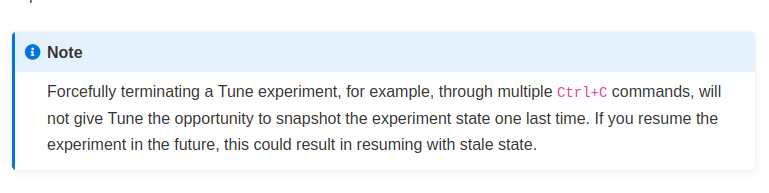

In [12]:
import numpy as np
from ray import tune

search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    'epochs':2
}

# Use GPU if available
if torch.cuda.is_available():
    device = "cuda"
    resources_per_trial = {"gpu": .5} # Podemos dividir el GPU
else:
    device = "cpu"
    resources_per_trial = {}


analysis = tune.run(
    CIFAR10Trainable, # Funcion de entrenamiento
    config=search_space, # Espacio de busqueda de Hyperparametros
    resources_per_trial=resources_per_trial, # recursos de entrenamiento
    stop={"training_iteration": search_space['epochs']},  # Epocas
    checkpoint_at_end=True,
    num_samples=1,  # Numero de Experimentos
)

2023-10-23 21:31:16,394	INFO worker.py:1642 -- Started a local Ray instance.
2023-10-23 21:31:20,264	INFO tune.py:228 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-10-23 21:31:20,267	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------------+
| Configuration for experiment     CIFAR10Trainable_2023-10-23_21-31-20   |
+-------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                  |
| Scheduler                        FIFOScheduler                          |
| Number of trials                 1                                      |
+-------------------------------------------------------------------------+

View detailed results here: /root/ray_results/CIFAR10Trainable_2023-10-23_21-31-20
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/CIFAR10Trainable_2023-10-23_21-31-20`

Trial status: 1 PENDING
Current time: 2023-10-23 21:31:21. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:None)
+-----------------------------------------+
| Trial name                     status   |
+----------

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_tune_results(analysis):
    # Extract data from analysis object
    dfs = analysis.trial_dataframes
    metric_data = {
        "iteration": [],
        "metric": [],
        "value": [],
    }

    for d in dfs.values():
        for metric in ["train_accuracy", "val_accuracy", "test_accuracy", "train_loss", "val_loss", "test_loss"]:
            if metric in d:
                for iteration, value in enumerate(d[metric]):
                    metric_data["iteration"].append(iteration)
                    metric_data["metric"].append(metric)
                    metric_data["value"].append(value)

    df = pd.DataFrame(metric_data)
    # Plotting accuracies
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df[df["metric"].isin(["train_accuracy", "val_accuracy", "test_accuracy"])],
                 x="iteration", y="value", hue="metric")
    plt.title("Accuracies over Iterations")
    plt.show()

    # Plotting losses
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df[df["metric"].isin(["train_loss", "val_loss", "test_loss"])],
                 x="iteration", y="value", hue="metric")
    plt.title("Losses over Iterations")
    plt.show()



(CIFAR10Trainable pid=82511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/CIFAR10Trainable_2023-10-23_21-31-20/CIFAR10Trainable_81d1b_00000_0_2023-10-23_21-31-21/checkpoint_000000)


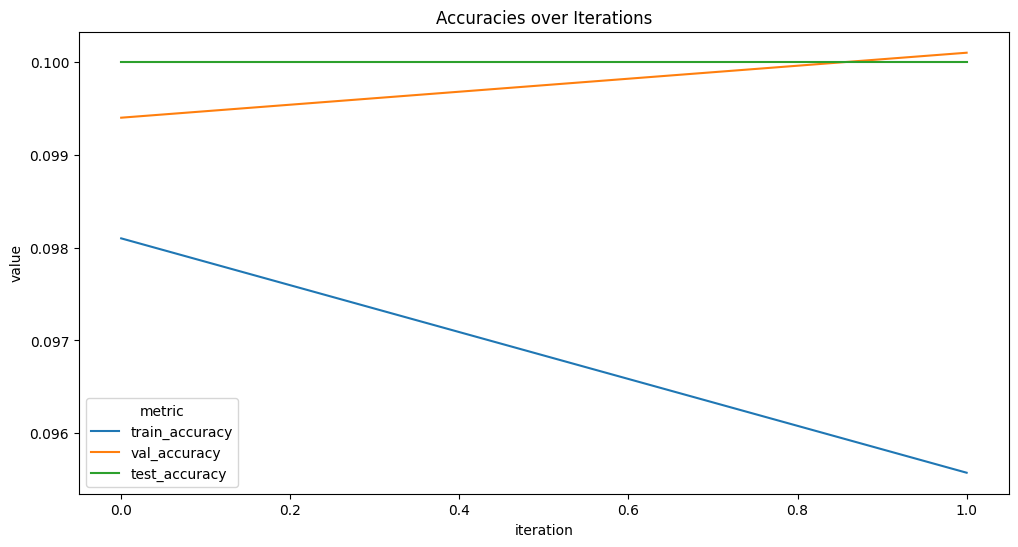

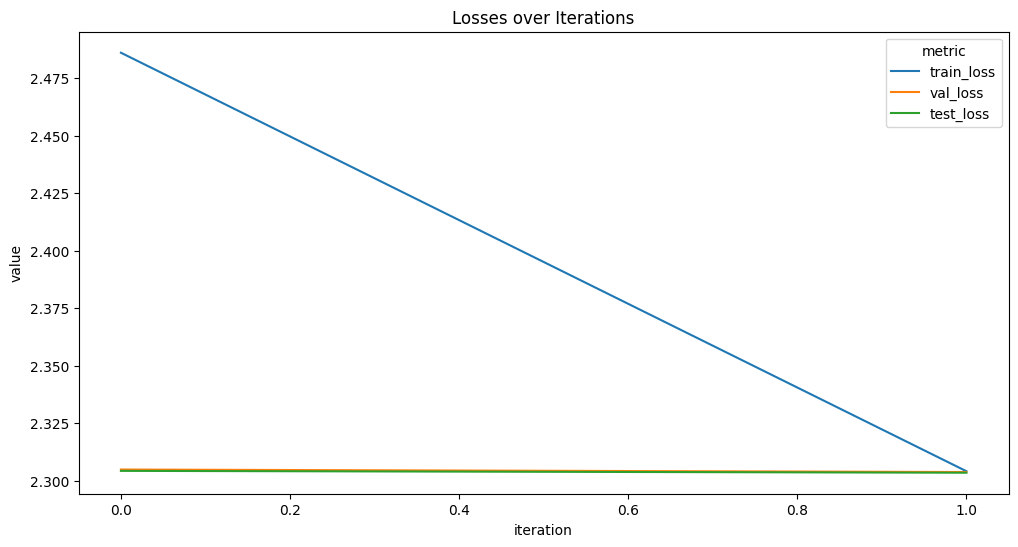

In [14]:
plot_tune_results(analysis)

Carguemos el mejor modelo, que metrica usamos para cargar el mejor modelo?

In [24]:
from sklearn.metrics import matthews_corrcoef
def compute_metrics(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_samples = 0
    total_loss = 0
    all_preds = []
    all_labels = []

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            total_loss += loss.item() * inputs.size(0)

            # Append for MCC
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100.0 * total_correct / total_samples
    avg_loss = total_loss / total_samples
    mcc = matthews_corrcoef(all_labels, all_preds) if len(set(all_labels)) > 1 else 0  # Handle cases where only one class is present

    return {"loss": avg_loss, "accuracy": accuracy, "mcc": mcc}

def evaluate_best_model(analysis, metric, direction='max'):
    try:
        best_trial = analysis.get_best_trial(metric, direction, 'last')
        best_checkpoint = best_trial.checkpoint.path
    except:
        return 0

    state_dict = torch.load(os.path.join(best_checkpoint, "checkpoint.pth"))['model_state_dict']

    try:
        model = Net()
        model.load_state_dict(state_dict)
    except:
        model = BatchNNet()
        model.load_state_dict(state_dict)

    # 1. Setup your test dataloader:
    cifar10_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])
    test_dataset = torchvision.datasets.CIFAR10(root="~/data", train=False, download=True, transform=cifar10_transforms)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 3. Use the function to evaluate the model:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    metrics = compute_metrics(model, test_loader, device)



In [16]:
results = evaluate_best_model(analysis, 'cual?', 'max')
results

Files already downloaded and verified


{'loss': 2.3034924423217773, 'accuracy': 10.0, 'mcc': 0.0}

## ASHAScheduler

### Explicacion

La función `ASHAScheduler` de Ray Tune es una herramienta para programar y administrar la ejecución de experimentos de búsqueda de hiperparámetros utilizando el algoritmo Asynchronous Successive Halving (ASHA).  
  
[Paper de ASHAScheduler](https://openreview.net/forum?id=S1Y7OOlRZ)


ASHA es eficiente porque permite que las pruebas prometedoras se ejecuten durante más iteraciones, mientras que las pruebas menos prometedoras se detienen temprano.


1. Inicialización de Pruebas: Se inicia un conjunto de pruebas de hiperparámetros, cada una con una configuración diferente. Estas pruebas se ejecutan simultáneamente, y cada una se evalúa en función de una métrica de rendimiento específica, como la precisión en un conjunto de validación.

2. Evaluación de Pruebas: Las pruebas se ejecutan durante un número fijo de iteraciones (definido por el parámetro `max_t`). En cada iteración, se recopilan métricas de rendimiento. La métrica seleccionada para la evaluación (definida por el parámetro `metric`) se utiliza para comparar y clasificar las pruebas en función de su rendimiento actual.

3. Eliminación de Pruebas: Después de un número mínimo de iteraciones (definido por el parámetro `grace_period`), ASHA realiza una ronda de eliminación. En esta ronda, las pruebas con peor rendimiento en la métrica se descartan. La cantidad de pruebas eliminadas en cada ronda se controla mediante el parámetro reduction_factor.

4. Repetición de Iteraciones: Las pruebas restantes continúan ejecutándose en las siguientes iteraciones. Se recopilan métricas adicionales, y se repiten las rondas de eliminación hasta que solo quede una prueba o un pequeño número de pruebas.

5. Selección del Mejor Modelo: Finalmente, ASHA selecciona la prueba que ha mostrado el mejor rendimiento en la métrica objetivo durante todas las rondas de eliminación. La configuración de hiperparámetros asociada a esta prueba se considera la mejor combinación de hiperparámetros encontrada hasta el momento.

Que metrica(s) nos conviene utilizar para parar/eliminar el experimento?


### Codigo

`metric` (métrica):  
    Este parámetro especifica la métrica que se utilizará como criterio para evaluar el rendimiento de cada ejecución de entrenamiento. En este caso, se está utilizando "val_accuracy" como métrica, lo que significa que se está maximizando la precisión en el conjunto de validación.

`mode` (modo):  
    Este parámetro indica si se debe maximizar o minimizar la métrica especificada. En tu ejemplo, se ha establecido en "max", lo que significa que se intentará maximizar la métrica de validación.

`max_t` (máximo de iteraciones):  
    Este parámetro define el número máximo de iteraciones que una prueba individual puede ejecutarse antes de ser detenida. En este caso, se ha configurado en 10, lo que significa que cada ejecución de prueba (entrenamiento de modelo) se detendrá después de 10 iteraciones.

`grace_period` (período de gracia):  
    El período de gracia es el número mínimo de iteraciones que se deben ejecutar antes de que una prueba pueda ser detenida por ASHA. En este caso, se ha establecido en 1, lo que significa que una prueba debe ejecutarse al menos una vez antes de que ASHA pueda tomar una decisión sobre si detenerla o no.

`reduction_factor` (factor de reducción):  
    El factor de reducción es un parámetro que controla cómo ASHA decide cuándo detener las pruebas. ASHA realiza una serie de rondas de eliminación en las que las pruebas menos prometedoras se detienen. El factor de reducción controla cuántas pruebas se eliminan en cada ronda. En este caso, se ha configurado en 2, lo que significa que en cada ronda, ASHA eliminará la mitad de las pruebas menos prometedoras.

In [17]:
from ray.tune.schedulers import ASHAScheduler
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "epochs":3
}

# Set up the ASHA scheduler
asha_scheduler = ASHAScheduler(
    metric="val_accuracy", # Metrica a evaluar
    mode="max",  # Queremos maximizar
    max_t=search_space['epochs'],    # Numero maximo de iteraciones un trial/experimento puede ejecutarse
    grace_period=1,  # Numero minimo de ejecuciones
    reduction_factor=2 # Modelos eliminados por ronda
)

analysis = tune.run(
    CIFAR10Trainable,
    config=search_space,
    resources_per_trial=resources_per_trial,
    scheduler=asha_scheduler,
    num_samples=4,  # Numero de Experimentos
    checkpoint_at_end=True

)


2023-10-23 21:32:33,459	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------------+
| Configuration for experiment     CIFAR10Trainable_2023-10-23_21-32-33   |
+-------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                  |
| Scheduler                        AsyncHyperBandScheduler                |
| Number of trials                 4                                      |
+-------------------------------------------------------------------------+

View detailed results here: /root/ray_results/CIFAR10Trainable_2023-10-23_21-32-33
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/CIFAR10Trainable_2023-10-23_21-32-33`

Trial status: 4 PENDING
Current time: 2023-10-23 21:32:33. Total running time: 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+-----------------------------------------+
| Trial name                     status   |
+--------

(CIFAR10Trainable pid=82870) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/CIFAR10Trainable_2023-10-23_21-32-33/CIFAR10Trainable_ad5c7_00001_1_2023-10-23_21-32-33/checkpoint_000000)


(CIFAR10Trainable pid=83583) Files already downloaded and verified [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)

Trial CIFAR10Trainable_ad5c7_00002 started with configuration:
+--------------------------------------------------+
| Trial CIFAR10Trainable_ad5c7_00002 config        |
+--------------------------------------------------+
| epochs                                         3 |
| lr                                             0 |
+--------------------------------------------------+

Trial CIFAR10Trainable_ad5c7_00003 started with configuration:
+--------------------------------------------------+
| Trial CIFAR10Trainable_ad5c7_00003 config        |
+--------------------------------------------------+
| epochs                                         3 |
| lr                                             0 

(CIFAR10Trainable pid=83601) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/CIFAR10Trainable_2023-10-23_21-32-33/CIFAR10Trainable_ad5c7_00003_3_2023-10-23_21-32-33/checkpoint_000000) [repeated 2x across cluster]



Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-10-23 21:36:04. Total running time: 3min 30s
Logical resource usage: 0/2 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:None)
+------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                     status         iter     total time (s)            lr     train_loss     train_accuracy     val_loss |
+------------------------------------------------------------------------------------------------------------------------------------+
| CIFAR10Trainable_ad5c7_00002   RUNNING           1            41.731    4.87401e-06        2.19001           0.22205       2.0119  |
| CIFAR10Trainable_ad5c7_00000   TERMINATED        3           138.593    1.56754e-06        2.08937           0.2721        2.04332 |
| CIFAR10Trainable_ad5c7_00001   TERMINATED        3           138.285    6.92781e-06        1.75075           0.376575      1.72094 |
| CIFAR10

(CIFAR10Trainable pid=83583) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/CIFAR10Trainable_2023-10-23_21-32-33/CIFAR10Trainable_ad5c7_00002_2_2023-10-23_21-32-33/checkpoint_000000)


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def visualize_results(analysis, hyperparameter):
    dfs = analysis.trial_dataframes

    # Create an empty dataframe to store metrics and hyperparameters
    data = []

    for trial_str, df in dfs.items():
        hyperparam_value = analysis.trial_dataframes[trial_str][hyperparameter].values[0]

        for metric in ["train_accuracy", "val_accuracy", "test_accuracy", "train_loss", "val_loss", "test_loss"]:
            for idx, value in df[metric].items():
                data.append({
                    "iteration": idx,
                    "metric": metric,
                    hyperparameter: hyperparam_value,
                    "value": value
                })

    df = pd.DataFrame(data)
    df[['set', 'metrica']] = df['metric'].str.split('_', 1, expand=True)

    g = sns.FacetGrid(df, col="set", row="metrica", hue=hyperparameter,
                      sharex=True, legend_out=True, sharey='row')
    g.map_dataframe(sns.lineplot, x="iteration", y='value')

    # Añade la leyenda al gráfico
    #g.add_legend(loc='center right')  # Puedes ajustar 'loc' según tu preferencia (por ejemplo, 'upper right', 'lower left', etc.)
    legend = plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
    for text in legend.get_texts():
        text.set_text(f'{float(text.get_text()):.1e}')
    # Ajusta el espaciado entre los gráficos
    plt.tight_layout()

    # Muestra los gráficos
    plt.show()




<ipython-input-18-86eb9fb26457>:25: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['set', 'metrica']] = df['metric'].str.split('_', 1, expand=True)


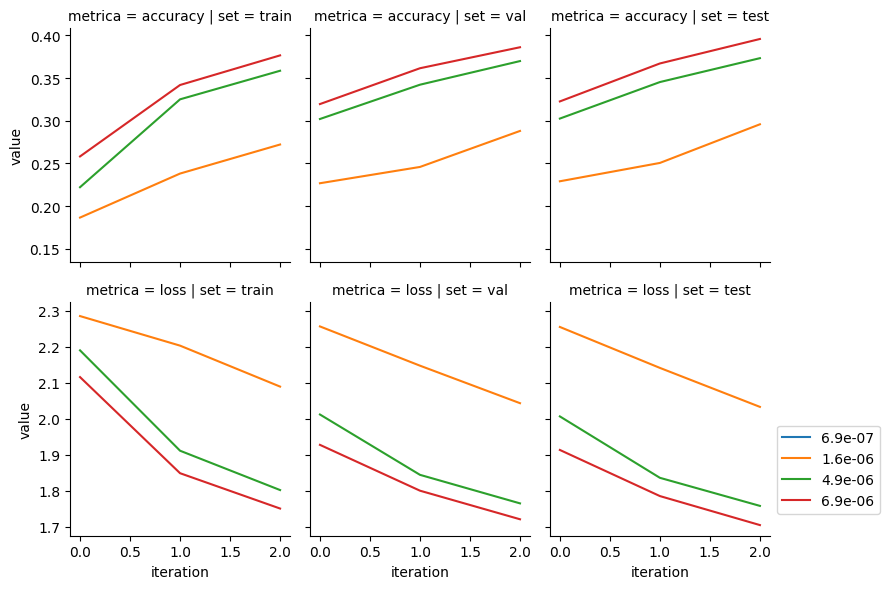

In [19]:
visualize_results(analysis, "lr")

In [25]:
results = evaluate_best_model(analysis, '?', 'max')
results

2023-10-23 21:38:34,692	WARNING experiment_analysis.py:596 -- Could not find best trial. Did you pass the correct `metric` parameter?


0

## ASHA Scheduler y HyperOpt

Hasta ahora hemos elegido de manera aleatoria (determinada por la distribucion) los posibles valores de los hyperparametros. Pero podemos mejorar la forma en que les elegimos si utilizamos algoritmos que tomen encuenta los resultados que se van obteniendo de experimentos anteriores.  
La idea es utilizar las metricas obtenidas para elegir mejor los hiperparametros. El hyperopt se puede utilizar sin necesidad del scheduler

Explica en que difieren cada forma de optimzar los hyperparametros, como son diferentes y como pueden convivir?

In [27]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

In [ ]:
search_space = {
    "lr": hp.loguniform("lr", -10, -1),
    "epochs":3
}

hyperopt_search = HyperOptSearch(search_space, metric="val_accuracy", mode="max")

# Set up the ASHA scheduler
asha_scheduler = ASHAScheduler(
    metric="val_accuracy", # Metrica a evaluar
    mode="max",  # Queremos maximizar
    max_t=search_space['epochs'],    # Numero maximo de iteraciones un trial/experimento puede ejecutarse
    grace_period=1,  # Numero minimo de ejecuciones
    reduction_factor=2 # Modelos eliminados por ronda
)

analysis = tune.run(
    CIFAR10Trainable,
    search_alg=hyperopt_search,
    resources_per_trial=resources_per_trial,
    scheduler=asha_scheduler,
    num_samples=4, # Numero de Experimentos
    checkpoint_at_end=True

)

2023-10-23 21:38:42,820	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------------+
| Configuration for experiment     CIFAR10Trainable_2023-10-23_21-38-42   |
+-------------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                        |
| Scheduler                        AsyncHyperBandScheduler                |
| Number of trials                 4                                      |
+-------------------------------------------------------------------------+

View detailed results here: /root/ray_results/CIFAR10Trainable_2023-10-23_21-38-42
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/CIFAR10Trainable_2023-10-23_21-38-42`

Trial status: 1 PENDING
Current time: 2023-10-23 21:38:42. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------+
| Trial name                  status   |
+--------------

(CIFAR10Trainable pid=84629) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/CIFAR10Trainable_2023-10-23_21-38-42/CIFAR10Trainable_aaf33dcf_2_epochs=3,lr=0.2671_2023-10-23_21-38-49/checkpoint_000000)


(CIFAR10Trainable pid=84916) Files already downloaded and verified
(CIFAR10Trainable pid=84916) Files already downloaded and verified

Trial CIFAR10Trainable_a9a4523e started with configuration:
+----------------------------------------------------+
| Trial CIFAR10Trainable_a9a4523e config             |
+----------------------------------------------------+
| epochs                                           3 |
| lr                                         0.00983 |
+----------------------------------------------------+

Trial CIFAR10Trainable_71c438af finished iteration 2 at 2023-10-23 21:40:11. Total running time: 1min 28s
+----------------------------------------------------+
| Trial CIFAR10Trainable_71c438af result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           39.5952 |
| time_total_s                               81.5295 |
| training_iteration                  

(CIFAR10Trainable pid=84916) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/CIFAR10Trainable_2023-10-23_21-38-42/CIFAR10Trainable_a9a4523e_3_epochs=3,lr=0.0098_2023-10-23_21-39-03/checkpoint_000000)



Trial status: 1 RUNNING | 2 TERMINATED | 1 PENDING
Current time: 2023-10-23 21:40:43. Total running time: 2min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status         iter     total time (s)            lr     train_loss     train_accuracy     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| CIFAR10Trainable_71c438af   RUNNING           2            81.5295   0.000423801        1.10281           0.606725      1.05775 |
| CIFAR10Trainable_aaf33dcf   TERMINATED        1            43.9318   0.267081       29126.1               0.099725     35.2804  |
| CIFAR10Trainable_a9a4523e   TERMINATED        1            40.9642   0.00983318         2.33609           0.098875      2.30356 |
| CIFAR10Trainab

(CIFAR10Trainable pid=84575) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/CIFAR10Trainable_2023-10-23_21-38-42/CIFAR10Trainable_71c438af_1_epochs=3,lr=0.0004_2023-10-23_21-38-42/checkpoint_000000)


(CIFAR10Trainable pid=85179) Files already downloaded and verified
(CIFAR10Trainable pid=85179) Files already downloaded and verified

Trial CIFAR10Trainable_efce5bd6 started with configuration:
+----------------------------------------------------+
| Trial CIFAR10Trainable_efce5bd6 config             |
+----------------------------------------------------+
| epochs                                           3 |
| lr                                         0.03863 |
+----------------------------------------------------+


In [ ]:
visualize_results(analysis, "lr")

In [ ]:
results = evaluate_best_model(analysis, '?', 'max')
results

## Batch Norm

In [ ]:
search_space = {
    "lr": hp.loguniform("lr", -10, -1),
    "epochs":2,
    "batch_norm": hp.choice('batch_norm', [True, False])
}

hyperopt_search = HyperOptSearch(search_space, metric="val_accuracy", mode="max")

# Set up the ASHA scheduler
asha_scheduler = ASHAScheduler(
    metric="val_accuracy", # Metrica a evaluar
    mode="max",  # Queremos maximizar
    max_t=search_space['epochs'],    # Numero maximo de iteraciones un trial/experimento puede ejecutarse
    grace_period=1,  # Numero minimo de ejecuciones
    reduction_factor=2 # Modelos eliminados por ronda
)

analysis = tune.run(
    CIFAR10Trainable,
    search_alg=hyperopt_search,
    resources_per_trial=resources_per_trial,
    scheduler=asha_scheduler,
    num_samples=10, # Numero de Experimentos
    checkpoint_at_end=True

)